In [58]:
import gym
from gym import spaces
import numpy as np

class BanditEnv(gym.Env):
    """
    Non-stationary K-armed bandit with truncated Gaussian rewards in [0, 1].
    The mean of each arm evolves over time (non-stationary), and rewards are clipped to [0, 1].
    """

    def __init__(self, n_arms=10, seed=None, drift_scale=0.01, reward_std=0.01):
        super(BanditEnv, self).__init__()
        self.n_arms = n_arms
        self.rng = np.random.default_rng(seed)
        self.drift_scale = drift_scale
        self.reward_std = reward_std

        self.action_space = spaces.Discrete(n_arms)
        self.observation_space = spaces.Discrete(1)

        # Choose a clear best arm
        self.best_arm = self.rng.integers(0, n_arms)

        # Initialize means: best arm has higher expected reward
        self.means = self.rng.uniform(0.2, 0.4, size=n_arms)
        self.means[self.best_arm] = self.rng.uniform(0.6, 0.9)
        self.t = 0
        self.best_arm = int(np.argmax(self.means))

    def reset(self):
        self.t = 0
        return 0

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"
        self.t += 1

        # Sample from a Gaussian and clip to [0, 1]
        reward = self.rng.normal(self.means[action], self.reward_std)
        reward = np.clip(reward, 0.0, 1.0)

        # Drift the means (simulate non-stationarity)
        self._drift_means()

        # Update best arm
        self.best_arm = int(np.argmax(self.means))

        done = False
        info = {
            "step": self.t,
            "expected_reward": self.means[action],
            "best_arm": self.best_arm,
            "best_expected_reward": self.means[self.best_arm],
            "optimal": (action == self.best_arm)
        }

        return 0, reward, done, info


    def _drift_means(self):
        # Add small Gaussian noise to simulate non-stationarity
        self.means += self.rng.normal(0, self.drift_scale, size=self.n_arms)
        self.means = np.clip(self.means, 0.0, 1.0)

    def render(self, mode="human"):
        print(f"Step {self.t} | Means: {np.round(self.means, 3)} | Best arm: {self.best_arm}")

    def seed(self, seed=None):
        self.rng = np.random.default_rng(seed)


### Classic EXP3 adapted for stochastic environments

**Algorithm: EXP3 in the Stochastic Setting**

**Initialize:**
- $t \gets 0$
- $\varepsilon_0 \gets \frac{1}{K}$
- For all $a \in \mathcal{A}$: $\hat{R}_0(a) \gets 0$

--

**For** $t = 1, 2, \dots$:

1. $\varepsilon_t \gets \min\left(\frac{1}{K}, \sqrt{\frac{\ln K}{K t}}\right)$
2. For all $a \in \mathcal{A}$:
   $$
   \tilde{w}_t(a) \gets (1 - K \varepsilon_t) \cdot \frac{e^{- \varepsilon_{t-1} \hat{R}_{t-1}(a)}}{\sum_{a' \in \mathcal{A}} e^{- \varepsilon_{t-1} \hat{R}_{t-1}(a')}} + \varepsilon_t
   $$
3. Draw action $a_t \sim \tilde{w}_t$ and play it  
4. Observe the reward $\ell_t$  
5. For all $a \in \mathcal{A}$:
   $$
   \hat{R}_t(a) \gets \hat{R}_{t-1}(a) + \frac{\ell_t}{\tilde{\rho}_t(a)} \cdot \mathbb{1}[a = a_t]
   $$

--

**End For**


In [63]:
class Exp3():
    """ Design Exp3 agent for stochastic environments """
    def __init__(self, K):
        self.K = K 
        self.reset()

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.t = 0 
        self.eps = 1 / self.K
        self.R = np.zeros(self.K)
        self.w = np.zeros(self.K)
        self.action_history = []

    def draw_action(self):
        self.t += 1
        t = self.t
        K = self.K
        eps_t = min(1 / K, np.sqrt(np.log(K) / (K * t)))
        num = np.exp(- self.eps * self.R)
        self.w = (1 - eps_t * K) * (num / np.sum(num)) + eps_t
        self.eps = eps_t
        action = self.rng.choice(range(K), p=self.w)
        self.index_action_chosen = action
        self.action_history.append(action)
        return action 
    
    def observe_reward(self, r):
        self.R[self.index_action_chosen] += r / self.w[self.index_action_chosen]

    def name(self):
        return 'Exp3'
        

### UCB (Upper Confidence Bound) Algorithm

**Initialize:**
- $K$: number of arms
- For all $a \in \mathcal{A}$:
  - $N_0(a) \gets 0$ (number of times arm $a$ has been pulled)
  - $\hat{\mu}_0(a) \gets 0$ (empirical mean reward for arm $a$)
- $t \gets 0$

--

**For** $t = 1, 2, \dots$:

1. **If** $t \leq K$:  
   Play arm $a_t = t \mod K$ (each arm once)

2. **Else**:
   - For each arm $a$:
     $$
     \text{UCB}_t(a) = \hat{\mu}_t(a) + \sqrt{\frac{2 \ln t}{N_t(a)}}
     $$
   - Choose arm:
     $$
     a_t = \arg\max_a \text{UCB}_t(a)
     $$

3. Play arm $a_t$ and observe reward $r_t$

4. Update:
   - $N_t(a_t) \gets N_t(a_t) + 1$
   - $\hat{\mu}_t(a_t) \gets$ updated empirical mean of arm $a_t$
   - $t \gets t + 1$

--

**End For**


In [64]:
class UCB:
  def __init__(self, K):
        self.action_set = np.arange(K)
        self.K = K
        self.reset()     

  def reset(self, seed=None):
      self.rng = np.random.default_rng(seed)
      self.total_reward = 0
      self.t = 0  
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.action_history = []
  
  def draw_action(self):
    if self.t < self.K:
        action = self.t % self.K
    else:
        with np.errstate(divide='ignore', invalid='ignore'):
                empirical_means = np.divide(self.count_rewards, self.count_actions, out=np.zeros_like(self.count_rewards), where=self.count_actions != 0)
                ucbs = np.sqrt(2 * np.log(self.t) / self.count_actions)
                scores = empirical_means + ucbs
                action = np.argmax(scores)

    self.t += 1
    self.count_actions[action] += 1
    self.chosen_action = action
    self.action_history.append(action)
    return action

  def observe_reward(self, reward):
    self.total_reward += reward
    self.count_rewards[self.chosen_action] += reward

  def name(self):
    return 'UCB' 

### EXP3ELM Algorithm (Stochastic Setting with Arm Elimination)

**Inputs:**
- Number of arms $K$
- Confidence parameter $\delta$

**Initialize:**
- $t \gets 0$
- $\varepsilon_0 \gets \frac{1}{K}$
- $\mathcal{A}_0 \gets \mathcal{A}$ (all arms are initially active)
- $B \gets 4(e - 2) \cdot \left(2 \ln K + \ln \frac{2}{\delta} \right)$
- For all $a \in \mathcal{A}$: $\hat{R}_0(a) \gets 0$, $\mathbb{V}_{R_0}(a) \gets 0$

--

**For** $t = 1, 2, \dots$:

1. $\varepsilon_t \gets \min\left(\frac{1}{K}, \sqrt{\frac{\ln K}{K t}}\right)$

2. For all $a \in \mathcal{A}_t$:
   $$
   \tilde{w}_t(a) \gets (1 - |\mathcal{A}_t| \cdot \varepsilon_t) \cdot \frac{e^{\varepsilon_{t-1} \hat{R}_{t-1}(a)}}{\sum_{a' \in \mathcal{A}_t} e^{\varepsilon_{t-1} \hat{R}_{t-1}(a')}} + \varepsilon_t
   $$

3. Sample action $a_t \sim \tilde{w}_t$ and play it

4. Observe reward $r_t$

5. For all $a \in \mathcal{A}_t$:
   $$
   \hat{R}_t(a) \gets \hat{R}_{t-1}(a) + \frac{r_t}{\tilde{w}_t(a)} \cdot \mathbb{1}[a = a_t]
   $$
   $$
   \mathbb{V}_{R_t}(a) \gets \mathbb{V}_{R_{t-1}}(a) + \frac{1}{\tilde{w}_t(a)}
   $$

6. Compute:
   - $\hat{R}_t^{\max} \gets \max_{a \in \mathcal{A}_t} \hat{R}_t(a)$  
   - $\hat{a}_t^* \gets \arg\max_{a \in \mathcal{A}_t} \hat{R}_t(a)$

7. Eliminate suboptimal arms:
   $$
   \mathcal{A}_t \gets \mathcal{A}_{t-1} \setminus \left\{ a \in \mathcal{A}_t \, : \, \hat{R}_t^{\max} - \hat{R}_t(a) > \sqrt{B \cdot \left(\mathbb{V}_{R_t}(\hat{a}_t^*) + \mathbb{V}_{R_t}(a) \right)} \right\}
   $$

--

**End For**


In [61]:
from math import exp, log

class Exp3ELM():
    """ EXP3 in stochastic settings with arm elimination """
    def __init__(self, K, delta=.1):
        self.K = K
        self.delta = delta
        self.reset()

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.eps = 1 / self.K
        self.action_set = np.arange(self.K)
        self.B = 4 * (exp(1) - 2) * (2 * log(self.K) + log(2/self.delta))
        self.R = np.zeros(self.K)
        self.V = self.K * np.ones(self.K)
        self.w = np.ones(self.K) / self.K
        self.t = 0
        self.action_history = []

    def draw_action(self):
        self.t += 1
        t = self.t
        K = self.K
        card_A = len(self.action_set)
        eps_t = min(1 / K, np.sqrt(np.log(K) / (K * t)))
        num = np.exp(- self.eps * self.R)
        self.w = (1 - card_A * eps_t) * (num / np.sum(num)) + eps_t
        action = self.rng.choice(self.action_set, p=self.w)
        self.index_action_chosen = action
        self.eps = eps_t
        self.action_history.append(action)
        return action

    def observe_reward(self, r):
        self.R[self.index_action_chosen] += r / self.w[self.index_action_chosen]
        self.V += 1 / self.w
        self.update_action_set()

    def update_action_set(self):
        a_max = np.argmax(self.R)
        R_max = np.max(self.R)
        print(self.V)
        lower_bounds = [np.sqrt(
                            self.B * (self.V[a_max] - self.V[a])) for a in self.action_set]
        action_set = []
        for i, lb in enumerate(lower_bounds):
            print(R_max - self.R[i], lb)
            if R_max - self.R[i] <= lb:
                action_set.append(i)
        self.action_set = np.array(action_set)
        self.w = self.w[action_set]
        self.w /= np.sum(self.w) 
        self.R = self.R[action_set]
        self.V = self.V[action_set]

    def name(self):
        return "Exp3ELM"

In [69]:
import seaborn as sns 
from tqdm import tqdm
colors = sns.color_palette('colorblind')
import matplotlib.pyplot as plt

def experiment(environment, agents, Nmc, T):
    all_data = {}
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)
        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))

    for episode in tqdm(range(Nmc)):
        environment.reset()
        agent.reset()   
        
        for t in range(T):
            index_action = agent.draw_action()
            _, r, _, info = environment.step(index_action)
            agent.observe_reward(r)

            # Compute pseudo-regret: 
            data[episode, t] = info["best_expected_reward"] - info["expected_reward"] 
    return agent.name(), data


def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None, UCB_regret=False):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()


import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Palette de couleurs (modifiable selon le nombre d'agents)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

def plot_regret_and_histogram(regrets, agents, env, logscale=False, lb=None, q=10, save_pdf=None, UCB_regret=False):
    """
    Plot cumulative regret and histogram of actions played by each agent.
    
    regrets : dict {'agent_name': np.array of regret}
    agents  : list of agent instances, each must have .action_history (flat list of actions played)
    """

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})
    ax_regret, ax_hist = axes

    # --- Regret plot ---
    for i, (agent_id, data) in enumerate(regrets.items()):
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

        ax_regret.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        ax_regret.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        ax_regret.set_xscale('log')
        ax_regret.set_xlim(left=100)

    if lb is not None:
        ax_regret.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    if UCB_regret:
        time_interval = np.arange(T)
        K = len(agents[0].action_set)
        UCB_bound = [np.sqrt(K * t * np.log(t)) for t in time_interval]
        ax_regret.plot(time_interval, UCB_bound, color="red", label=r'$\sqrt{K T \log T}$')

    ax_regret.set_ylabel("Cumulative Regret")
    ax_regret.set_xlabel("Time steps")
    ax_regret.legend()
    ax_regret.set_title("Cumulative Regret per Agent")

    # --- Histogram plot ---
    width = 0.8 / len(agents)  # Adjust width for overlap

    for i, agent in enumerate(agents):
        if not hasattr(agent, "action_history"):
            continue  # Skip if no action data

        action_counts = Counter(agent.action_history)
        actions = sorted(action_counts.keys())
        freqs = [action_counts[a] for a in actions]

        x = np.array(actions) + i * width - (len(agents)/2) * width + width/2
        ax_hist.bar(x, freqs, width=width, color=colors[i], alpha=0.8, label=agent.name())

    ax_hist.set_xlabel("Arm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(f"Actions Played by Each Agent (Best arm = {env.best_arm})")
    ax_hist.legend()

    plt.tight_layout()
    if save_pdf:
        plt.savefig(save_pdf)
    plt.show()


100%|██████████| 10/10 [00:00<00:00, 39.08it/s]


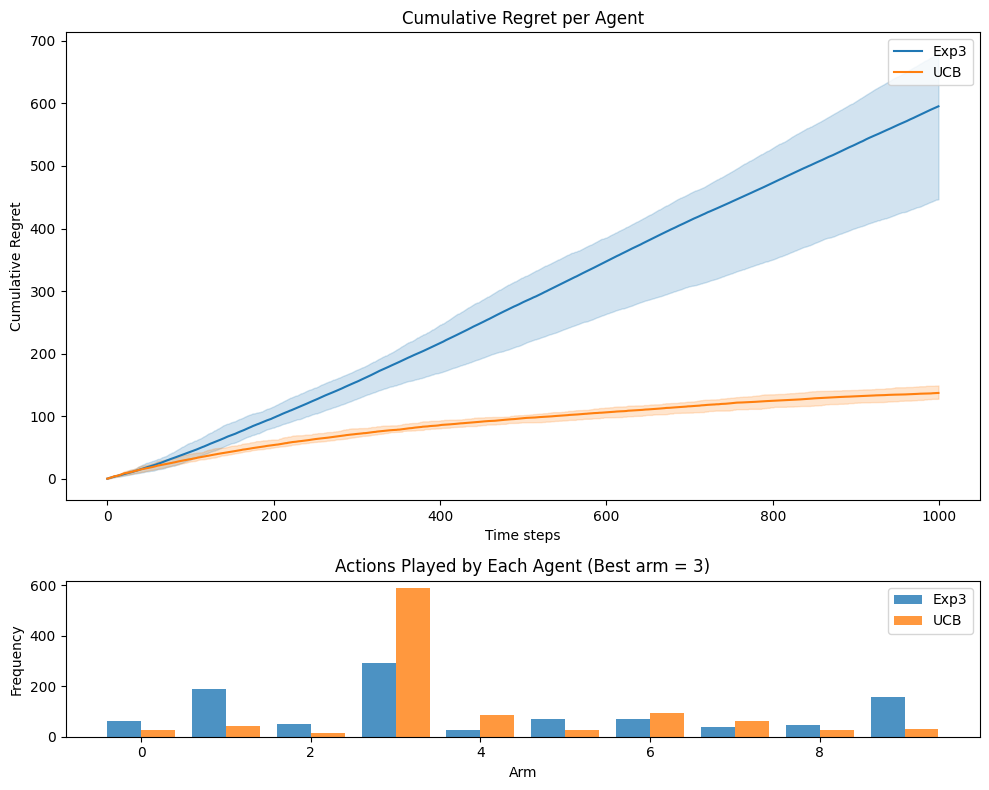

In [70]:
env = BanditEnv(n_arms=10, seed=None)
exp3 = Exp3(K=10)
ucb = UCB(K=10)
#exp3elm = Exp3ELM(K=10)

regrets = experiment(environment=env, agents=[exp3, ucb], Nmc=10, T=1000)
plot_regret_and_histogram(regrets, agents=[exp3, ucb], env=env, logscale=False, lb=None, q=10, save_pdf=None, UCB_regret=False)